Jalankan kode ini jika kita menggunakan Google Colab. Untuk prediksi yang lebih cepat, disarankan mengaktifkan mode GPU di Google Colab.

In [1]:
!git clone https://github.com/karuniaperjuangan/Twitter-Sentiment-Analysis-NLP-Pra-UTS.git
import os
os.chdir("Twitter-Sentiment-Analysis-NLP-Pra-UTS")

Cloning into 'Twitter-Sentiment-Analysis-NLP-Pra-UTS'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 40 (delta 9), reused 34 (delta 7), pack-reused 0
Unpacking objects: 100% (40/40), done.


In [3]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 8.3 MB/s 
     |████████████████████████████████| 5.3 MB 37.8 MB/s 
     |████████████████████████████████| 6.6 MB 36.1 MB/s 
     |████████████████████████████████| 163 kB 56.4 MB/s 
     |████████████████████████████████| 270 kB 59.4 MB/s 
     |████████████████████████████████| 57 kB 6.2 MB/s 
     |████████████████████████████████| 84 kB 3.2 MB/s 
     |████████████████████████████████| 84 kB 3.6 MB/s 
     |████████████████████████████████| 2.3 MB 58.3 MB/s 
     |████████████████████████████████| 55 kB 3.6 MB/s 
     |████████████████████████████████| 54 kB 3.2 MB/s 
     |████████████████████████████████| 112 kB 62.7 MB/s 
     |████████████████████████████████| 212 kB 58.4 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 80 kB 9.4 MB/s 
     |████████████████████████████████| 68 kB 

# Tugas NLP Sentiment Analysis

Pada tugas kali ini, kita akan melakukan sentiment Analysis terhadap teks yang discrape dari Twitter. Model yang kita gunakan adalah DistilBERT yang sudah ditraining dalam [Notebook yang berbeda](https://github.com/karuniaperjuangan/Twitter-Sentiment-Analysis-NLP-Pra-UTS/blob/main/training/Training%20Model.ipynb) dengan dataset Sentiment Analysis IndoNLU yang fokus pada bahasa Indonesia. Alasan penggunaan DistilBERT ada di slide presentasi. Kita di sini lebih fokus ke inferencing.

Import beberapa Library yang diperlukan dahulu

In [4]:
import gradio as gr # Untuk UI
from transformers import pipeline
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
import gc
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import snscrape.modules.twitter as sntwitter
import datetime as dt

Gunakan GPU jika memungkinkan.

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("GPU is available")
    print(torch.cuda.get_device_name(0))
    !nvidia-smi

# Scraping

Kita akan melakukan scraping Twitter dengan bantuan SNScrape. Kita akan lebih fokus ke isi teks Twitter.

In [23]:
def scrape_tweets(query, max_tweets=-1,output_path="./scraper/output/" ): 
    output_path = os.path.join(output_path,dt.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")+"-"+str(query)+".csv")
    
    tweets_list = []
    try:
        for i,tweet in tqdm(enumerate(sntwitter.TwitterSearchScraper(query).get_items())):
            if max_tweets != -1 and i >= int(max_tweets):
                break
            tweets_list.append([tweet.date, tweet.id, tweet.content])
    except KeyboardInterrupt:
        print("Scraping berhenti atas permintaan pengguna")
    df = pd.DataFrame(tweets_list, columns=['Datetime', 'Tweet Id', 'Text'])
    
    df.to_csv(output_path, index=False)
    print("Data tweet tersimpan di",output_path)
    return df

Agar lebih akurat dan lebih ringan, kita perlu melakukan *preprocessing* terlebih dahulu. Caranya adalah menghapus tag mention, URL, dan segala karakter non alfanumerik seperti tanda baca dan emoji.

In [ ]:
def remove_unnecessary_char(text):
  text = re.sub("\[USERNAME\]", " ", text)
  text = re.sub("\[URL\]", " ", text)
  text = re.sub("\[SENSITIVE-NO\]", " ", text)
  text = re.sub('  +', ' ', text)
  return text

def preprocess_tweet(text):
  text = re.sub('\n',' ',text) # Remove every '\n'
  # text = re.sub('rt',' ',text) # Remove every retweet symbol
  text = re.sub('^(\@\w+ ?)+',' ',text)
  text = re.sub(r'\@\w+',' ',text) # Remove every username
  text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
  text = re.sub('/', ' ', text)
  # text = re.sub(r'[^\w\s]', '', text)
  text = re.sub('  +', ' ', text) # Remove extra spaces
  return text
    
def remove_nonaplhanumeric(text):
  text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
  return text

def preprocess_text(text):
  text = preprocess_tweet(text)
  text = remove_unnecessary_char(text)
  text = remove_nonaplhanumeric(text)
  text = text.lower()
  return text

Kemudian kita bisa menggunakan pipeline `text-classification` dengan model yang sudah dibuat dan tersimpan sebagai model `karuniaperjuangan/smsa-distilbert-indo` di HuggingFace. Analisis sentimen ini dilakukan setelah proses scraping dan di akhir kita juga akan menampilkan plot Pie Chart.

In [19]:
predict = pipeline('text-classification',
                   model='karuniaperjuangan/smsa-distilbert-indo',
                    device=0 if torch.cuda.is_available() else -1)

def analyze_df_sentiment(df, batch_size):
    text_list = list(df["Text"].astype(str).values)
    text_list_batches = [text_list[i:i+batch_size] for i in range(0,len(text_list),batch_size)] # Memisahkan berdasar batch size dengan bantuan zip
    
    predictions = []
    for batch in tqdm(text_list_batches):
        batch_predictions = predict(batch)
        predictions += batch_predictions
    df["Label"] = [pred["label"] for pred in predictions]
    df["Score"] = [pred["score"] for pred in predictions]
    
    return df

def keyword_analyzer(keyword, max_tweets, batch_size=16):
    print("Scraping tweets...")
    df = scrape_tweets(keyword, max_tweets=max_tweets)
    df["Text"] = df["Text"].apply(preprocess_text)
    print("Analyzing sentiment...")
    df = analyze_df_sentiment(df, batch_size=batch_size)
    fig = plt.figure()
    df.groupby(["Label"])["Text"].count().plot.pie(autopct="%.1f%%", figsize=(6,6))
    return fig, df[["Text", "Label", "Score"]]
 

# Web UI

Kita di sini akan menjalankan aplikasi yang memiliki Web UI dengan bantuan Gradio. Kita bisa mencari berdasarkan Keyword yang ingin kita cari atau juga bisa mencoba dengan memasukkan satu teks.

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://10318.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


Scraping tweets...


100it [00:02, 44.70it/s]


Data tweet tersimpan di ./scraper/output/2022-10-08_11-46-33-dteti ugm.csv
Analyzing sentiment...


100%|██████████| 7/7 [00:08<00:00,  1.14s/it]


Scraping tweets...


100it [00:02, 41.23it/s]


Data tweet tersimpan di ./scraper/output/2022-10-08_11-47-18-anies baswedan.csv
Analyzing sentiment...


100%|██████████| 7/7 [00:06<00:00,  1.09it/s]


Keyboard interruption in main thread... closing server.


(<gradio.routes.App at 0x7f3dccddfc90>,
 'http://127.0.0.1:7861/',
 'https://10318.gradio.app')

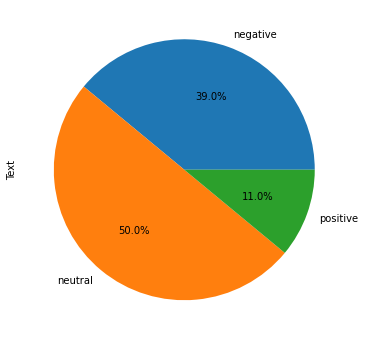

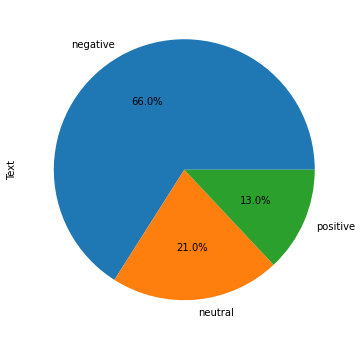

In [24]:
with gr.Blocks() as demo:
    


    gr.Markdown("""<h1 style="text-align:center">Aplikasi Sentiment Analysis Keyword Twitter </h1>""")
    
    gr.Markdown(
        """
        Aplikasi ini digunakan untuk melakukan sentimen analisis terhadap data di Twitter menggunakan model DistilBERT. Terdapat 2 mode yang dapat digunakan:
        1. Trend/Keyword: Untuk melakukan analisis terhadap semua tweet yang mengandung keyword yang diinputkan
        2. Tweet: Untuk melakukan analisis terhadap sebuah tweet yang diinputkan
        """
        
        )
    with gr.Tab("Trend/Keyword"):
        gr.Markdown("""Masukkan keyword dan jumlah maksimum tweet yang ingin diambil""")
        with gr.Blocks():
            with gr.Row():
                with gr.Column():
                    keyword_textbox = gr.Textbox(lines=1, label="Keyword")
                    max_tweets_component = gr.Number(value=-1, label="Tweet Maksimal yang akan discrape (-1 jika ingin mengscrape semua tweet)", precision=0)
                    batch_size_component = gr.Number(value=16, label="Batch Size (Semakin banyak semakin cepat, tetapi semakin boros memori)", precision=0)
                    button = gr.Button("Submit")
                    
                plot_component = gr.Plot(label="Pie Chart")
            dataframe_component = gr.DataFrame(type="pandas", 
                                               label="Dataframe", 
                                               max_rows=(20,'fixed'), 
                                               overflow_row_behaviour='paginate', 
                                               wrap=True)

        
        
    with gr.Tab("Single Tweet"):
        gr.Interface(lambda Tweet: (predict(Tweet)[0]['label'], predict(Tweet)[0]['score']), 
                     "textbox",
                     ["label", "label"],
                     allow_flagging='never',
                     )
    
    
    gr.Markdown(
            """
            
            ## Anggota Kelompok
            
            - Karunia Perjuangan Mustadl'afin - 20/456368/TK/50498
            
            - Pramudya Kusuma Hardika - 20/460558/TK/51147
            
            """
            
        )
    
    button.click(keyword_analyzer, 
                inputs=[keyword_textbox, max_tweets_component, batch_size_component], 
                outputs=[plot_component, dataframe_component])

demo.launch(inbrowser=True, debug=True)